# ESCMID AI Course - Day 2: Machine Learning for Antibiotic Resistance Prediction

## Overview
This notebook demonstrates comprehensive machine learning approaches for predicting antibiotic resistance using the AHC (Angkor Hospital for Children) dataset. We will cover:

1. **Data Loading and Exploration**
2. **Model Development Strategies**
3. **Cross-Validation Techniques**
4. **Performance Metrics and Evaluation**
5. **Model Comparison and Selection**

### Learning Objectives
- Understand different machine learning algorithms for classification
- Learn proper model validation techniques
- Implement cross-validation for robust performance estimation
- Compare multiple models systematically
- Interpret performance metrics in clinical context

In [28]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                           roc_auc_score, confusion_matrix, classification_report, 
                           roc_curve, precision_recall_curve)

# Model persistence
import joblib

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## 1. Data Loading and Exploration

The AHC final dataset contains preprocessed features from the Angkor Hospital for Children study. The data has been:
- One-hot encoded for categorical variables
- Normalized for continuous variables
- Cleaned for missing values

The target variable is `amp.gent.treatable` which indicates whether the infection is treatable with ampicillin-gentamicin combination therapy.

In [ ]:
# Load the preprocessed dataset
df = pd.read_csv('../../DAY_1/DATA/AHC_final_dataset.csv')

print(f"Dataset shape: {df.shape}")
print(f"Features: {df.shape[1] - 1}")
print(f"Samples: {df.shape[0]}")

# Display first few rows
df.head()

FileNotFoundError: [Errno 2] No such file or directory: '../../DAY_1/AHC_final_dataset.csv'

In [30]:
# Prepare features and target
X = df.drop('amp.gent.treatable', axis=1)
y = df['amp.gent.treatable']

# Convert target to binary (Y=1, N=0)
y_binary = (y == 'Y').astype(int)

print("Target variable distribution:")
print(y.value_counts())
print(f"\nClass balance: {y.value_counts(normalize=True)}")

# Check for any missing values
print(f"\nMissing values in features: {X.isnull().sum().sum()}")
print(f"Missing values in target: {y.isnull().sum()}")

print(f"\nFeature data types:")
print(X.dtypes.value_counts())

Target variable distribution:
amp.gent.treatable
Y    158
N     85
Name: count, dtype: int64

Class balance: amp.gent.treatable
Y    0.650206
N    0.349794
Name: proportion, dtype: float64

Missing values in features: 0
Missing values in target: 0

Feature data types:
bool       57
int64       6
float64     1
Name: count, dtype: int64


## 2. Understanding Machine Learning Algorithms for Classification

Before diving into model implementation, let's understand the different types of algorithms we'll use:

### Linear Models
- **Logistic Regression**: Uses a linear combination of features with sigmoid activation. Good for interpretability and baseline performance.

### Tree-Based Models
- **Random Forest**: Ensemble of decision trees with voting. Handles non-linear relationships and feature interactions well.
- **Gradient Boosting**: Sequential ensemble that corrects previous model errors. Often achieves high performance.

### Instance-Based Models
- **K-Nearest Neighbors (KNN)**: Makes predictions based on similarity to training examples. Non-parametric and intuitive.

### Probabilistic Models
- **Naive Bayes**: Assumes feature independence given the class. Fast and works well with small datasets.

### Kernel Methods
- **Support Vector Machine (SVM)**: Finds optimal decision boundary with maximum margin. Can handle non-linear relationships with kernels.

In [31]:
# Initialize models with balanced class weights where applicable
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100),
    'SVM': SVC(class_weight='balanced', random_state=42, probability=True),
    'Naive Bayes': GaussianNB(),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

# For algorithms that benefit from feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Models initialized:")
for name in models.keys():
    print(f"- {name}")
print(f"\nDataset prepared with {X.shape[1]} features and {X.shape[0]} samples")

Models initialized:
- Logistic Regression
- Random Forest
- Gradient Boosting
- SVM
- Naive Bayes
- KNN

Dataset prepared with 64 features and 243 samples


## 3. Cross-Validation: The Gold Standard for Model Evaluation

Cross-validation is essential for getting robust estimates of model performance and avoiding overfitting.

### Why Cross-Validation?
1. **Reduces overfitting**: Uses multiple train/test splits
2. **Better performance estimates**: Averages across multiple folds
3. **Model selection**: Helps choose the best algorithm
4. **Hyperparameter tuning**: Finds optimal parameters

### Stratified K-Fold Cross-Validation
We use stratified k-fold to maintain class balance across folds, which is crucial for imbalanced datasets like ours.

In [32]:
# Perform cross-validation for all models
cv_scores = {}
cv_folds = 5
skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

print("Performing 5-fold stratified cross-validation...")
print("-" * 60)

for name, model in models.items():
    # Use scaled features for algorithms that benefit from it
    if name in ['Logistic Regression', 'SVM', 'KNN', 'Naive Bayes']:
        X_input = X_scaled
    else:
        X_input = X
    
    # Calculate cross-validation scores
    scores = cross_val_score(model, X_input, y_binary, cv=skf, scoring='roc_auc')
    cv_scores[name] = scores
    
    print(f"{name:20s} | AUC: {scores.mean():.3f} ± {scores.std():.3f} | Range: [{scores.min():.3f}, {scores.max():.3f}]")

print("-" * 60)

Performing 5-fold stratified cross-validation...
------------------------------------------------------------
Logistic Regression  | AUC: 0.561 ± 0.047 | Range: [0.504, 0.634]
Random Forest        | AUC: 0.660 ± 0.029 | Range: [0.613, 0.699]
Gradient Boosting    | AUC: 0.543 ± 0.062 | Range: [0.435, 0.605]
SVM                  | AUC: 0.638 ± 0.087 | Range: [0.509, 0.750]
Naive Bayes          | AUC: 0.590 ± 0.054 | Range: [0.495, 0.655]
KNN                  | AUC: 0.627 ± 0.093 | Range: [0.472, 0.747]
------------------------------------------------------------


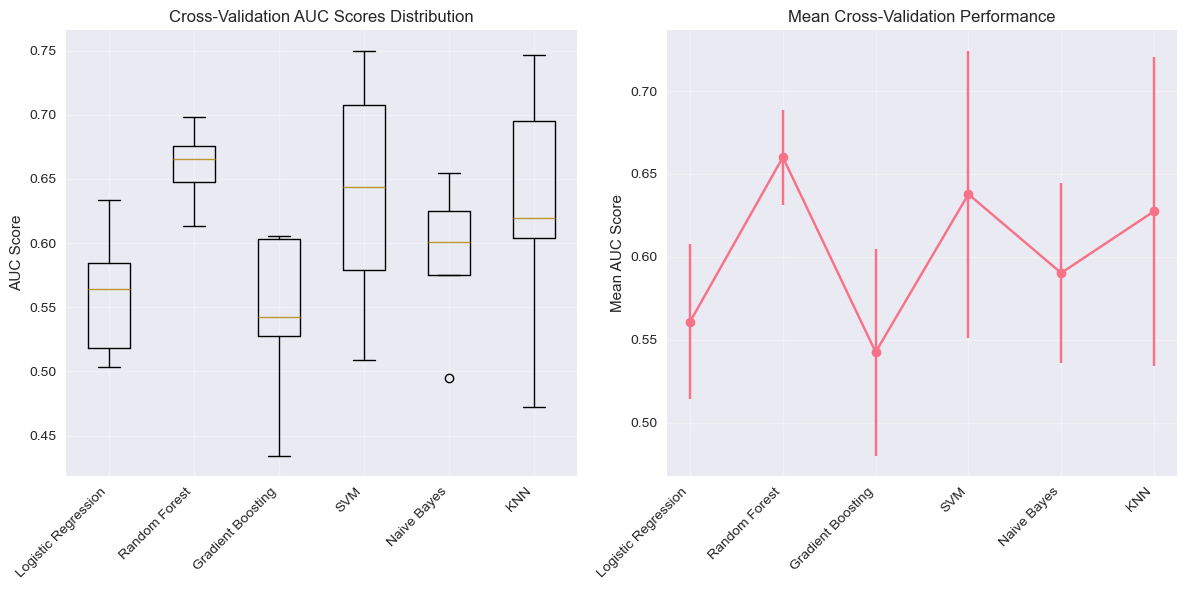


Model Ranking (by mean AUC):
----------------------------------------
1. Random Forest        0.660 ± 0.029
2. SVM                  0.638 ± 0.087
3. KNN                  0.627 ± 0.093
4. Naive Bayes          0.590 ± 0.054
5. Logistic Regression  0.561 ± 0.047
6. Gradient Boosting    0.543 ± 0.062


In [33]:
# Visualize cross-validation results
plt.figure(figsize=(12, 6))

# Box plot of CV scores
plt.subplot(1, 2, 1)
cv_data = [cv_scores[name] for name in models.keys()]
plt.boxplot(cv_data, labels=list(models.keys()))
plt.xticks(rotation=45, ha='right')
plt.ylabel('AUC Score')
plt.title('Cross-Validation AUC Scores Distribution')
plt.grid(True, alpha=0.3)

# Mean CV scores with error bars
plt.subplot(1, 2, 2)
means = [cv_scores[name].mean() for name in models.keys()]
stds = [cv_scores[name].std() for name in models.keys()]
plt.errorbar(range(len(models)), means, yerr=stds, marker='o', capsize=5)
plt.xticks(range(len(models)), list(models.keys()), rotation=45, ha='right')
plt.ylabel('Mean AUC Score')
plt.title('Mean Cross-Validation Performance')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Rank models by performance
model_ranking = sorted([(name, scores.mean(), scores.std()) for name, scores in cv_scores.items()], 
                      key=lambda x: x[1], reverse=True)

print("\nModel Ranking (by mean AUC):")
print("-" * 40)
for i, (name, mean_score, std_score) in enumerate(model_ranking, 1):
    print(f"{i}. {name:20s} {mean_score:.3f} ± {std_score:.3f}")

## 4. Understanding Performance Metrics

In healthcare applications, different metrics tell different stories:

### Key Metrics for Binary Classification

1. **Accuracy**: Overall correctness, but can be misleading with imbalanced classes
2. **Precision (Positive Predictive Value)**: Of predicted resistant cases, how many are actually resistant?
3. **Recall (Sensitivity)**: Of actually resistant cases, how many did we correctly identify?
4. **Specificity**: Of actually treatable cases, how many did we correctly identify?
5. **F1-Score**: Harmonic mean of precision and recall
6. **AUC-ROC**: Area under ROC curve, measures ability to distinguish classes
7. **AUC-PR**: Area under precision-recall curve, better for imbalanced datasets

### Clinical Interpretation
- **High Sensitivity**: Important to not miss resistant infections (avoid treatment failure)
- **High Specificity**: Important to not over-treat with broad-spectrum antibiotics
- **Balance**: Need to consider both false positives (unnecessary broad-spectrum therapy) and false negatives (treatment failure)

In [34]:
# Detailed evaluation on train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, 
                                                    random_state=42, stratify=y_binary)

# Scale features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train models and collect detailed metrics
detailed_results = {}

for name, model in models.items():
    # Select appropriate input data
    if name in ['Logistic Regression', 'SVM', 'KNN', 'Naive Bayes']:
        X_train_input = X_train_scaled
        X_test_input = X_test_scaled
    else:
        X_train_input = X_train
        X_test_input = X_test
    
    # Train model
    model.fit(X_train_input, y_train)
    
    # Predictions
    y_pred = model.predict(X_test_input)
    y_pred_proba = model.predict_proba(X_test_input)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics
    results = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
        'specificity': recall_score(1-y_test, 1-y_pred, zero_division=0),
    }
    
    if y_pred_proba is not None:
        results['auc_roc'] = roc_auc_score(y_test, y_pred_proba)
        # Calculate AUC-PR
        precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
        results['auc_pr'] = np.trapz(precision_curve, recall_curve)
    
    detailed_results[name] = results

print("Detailed Performance Metrics on Test Set:")
print("=" * 80)
print(f"{'Model':<20} {'Acc':<6} {'Prec':<6} {'Rec':<6} {'Spec':<6} {'F1':<6} {'AUC-ROC':<7} {'AUC-PR':<6}")
print("-" * 80)

for name, results in detailed_results.items():
    auc_roc = results.get('auc_roc', 0)
    auc_pr = results.get('auc_pr', 0)
    print(f"{name:<20} {results['accuracy']:<6.3f} {results['precision']:<6.3f} "
          f"{results['recall']:<6.3f} {results['specificity']:<6.3f} {results['f1']:<6.3f} "
          f"{auc_roc:<7.3f} {auc_pr:<6.3f}")

Detailed Performance Metrics on Test Set:
Model                Acc    Prec   Rec    Spec   F1     AUC-ROC AUC-PR
--------------------------------------------------------------------------------
Logistic Regression  0.531  0.696  0.500  0.588  0.582  0.564   -0.698
Random Forest        0.653  0.714  0.781  0.412  0.746  0.661   -0.771
Gradient Boosting    0.633  0.750  0.656  0.588  0.700  0.605   -0.700
SVM                  0.531  0.696  0.500  0.588  0.582  0.583   -0.737
Naive Bayes          0.510  0.700  0.438  0.647  0.538  0.546   -0.690
KNN                  0.531  0.636  0.656  0.294  0.646  0.531   -0.703


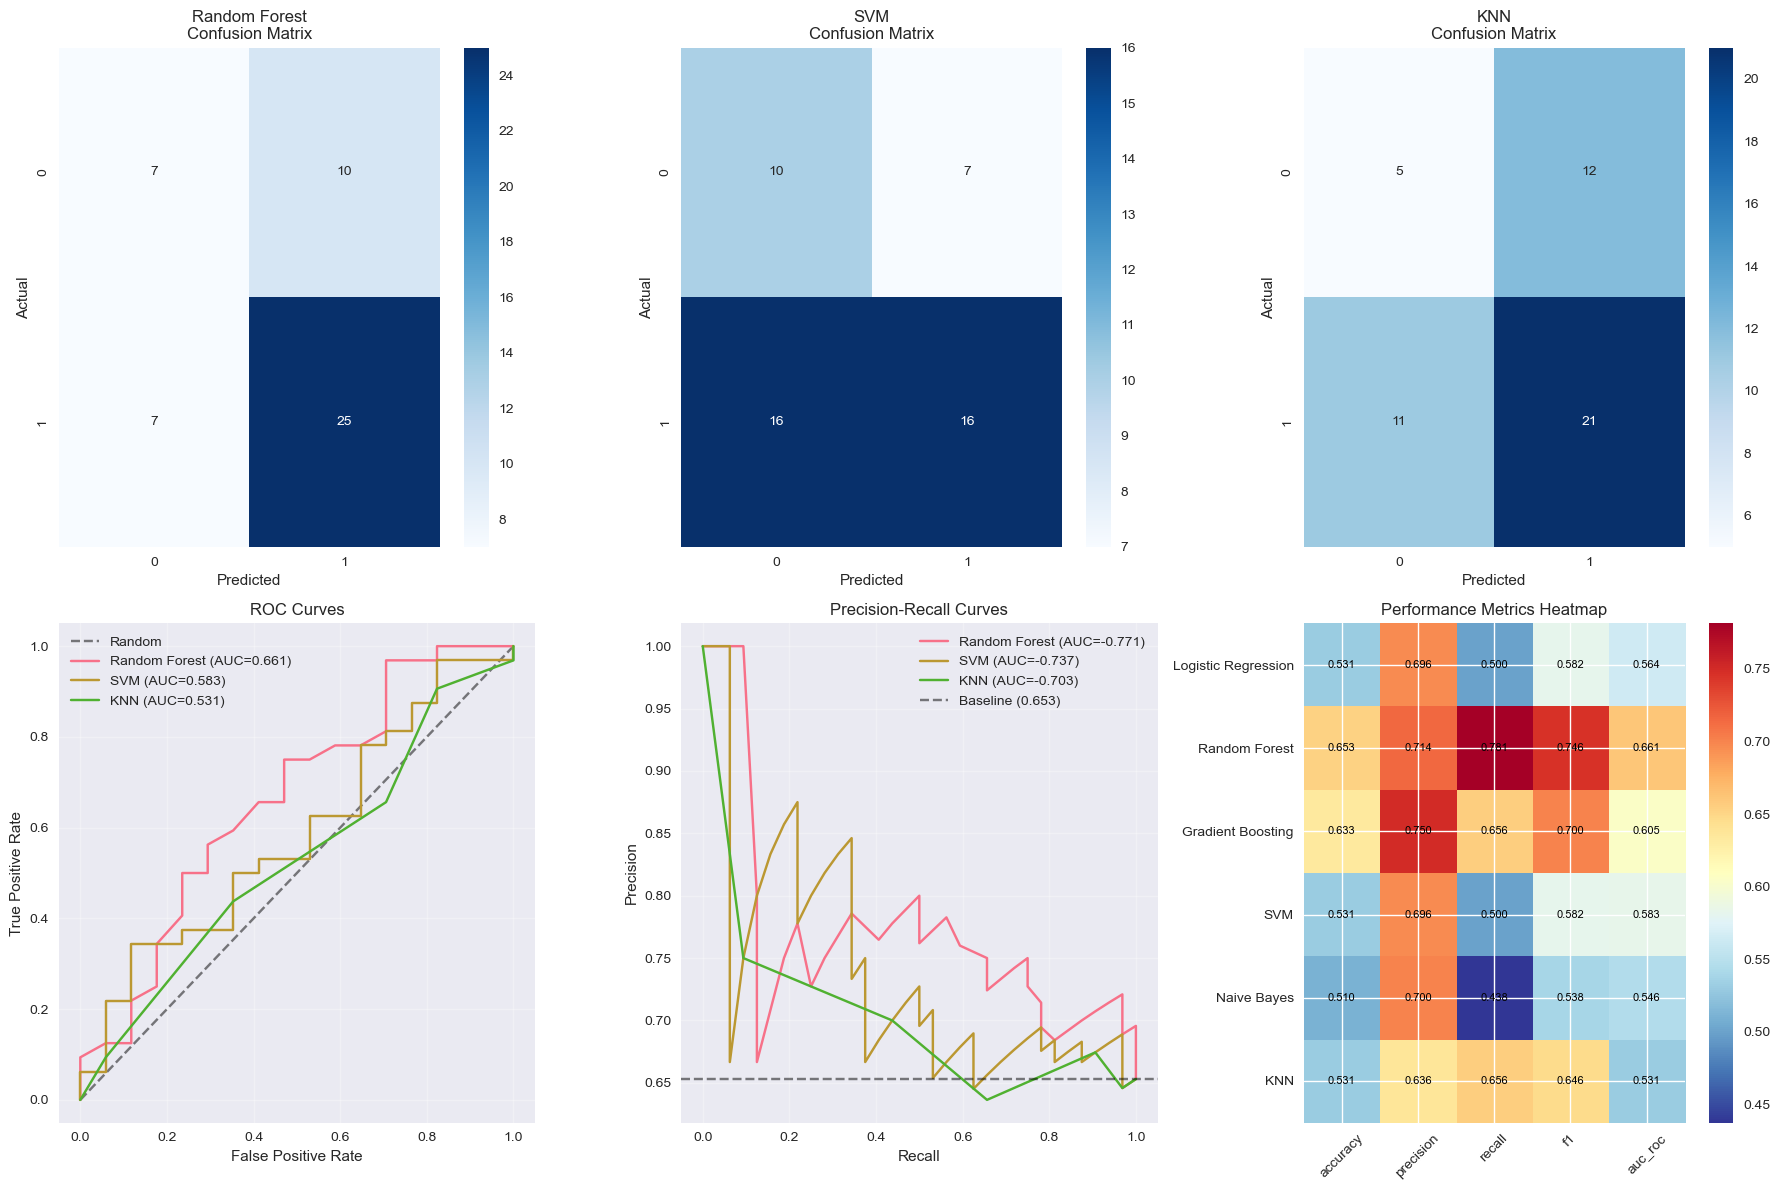

In [35]:
# Create comprehensive visualization of model performance
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Confusion matrices for top 3 models
top_3_models = [name for name, _, _ in model_ranking[:3]]

for i, model_name in enumerate(top_3_models):
    model = models[model_name]
    if model_name in ['Logistic Regression', 'SVM', 'KNN', 'Naive Bayes']:
        X_train_input = X_train_scaled
        X_test_input = X_test_scaled
    else:
        X_train_input = X_train
        X_test_input = X_test
    
    model.fit(X_train_input, y_train)
    y_pred = model.predict(X_test_input)
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, i])
    axes[0, i].set_title(f'{model_name}\nConfusion Matrix')
    axes[0, i].set_ylabel('Actual')
    axes[0, i].set_xlabel('Predicted')

# 2. ROC curves
axes[1, 0].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
for model_name in top_3_models:
    model = models[model_name]
    if model_name in ['Logistic Regression', 'SVM', 'KNN', 'Naive Bayes']:
        X_test_input = X_test_scaled
    else:
        X_test_input = X_test
    
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test_input)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc = roc_auc_score(y_test, y_pred_proba)
        axes[1, 0].plot(fpr, tpr, label=f'{model_name} (AUC={auc:.3f})')

axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].set_title('ROC Curves')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 3. Precision-Recall curves
for model_name in top_3_models:
    model = models[model_name]
    if model_name in ['Logistic Regression', 'SVM', 'KNN', 'Naive Bayes']:
        X_test_input = X_test_scaled
    else:
        X_test_input = X_test
    
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test_input)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        auc_pr = np.trapz(precision, recall)
        axes[1, 1].plot(recall, precision, label=f'{model_name} (AUC={auc_pr:.3f})')

# Add baseline (proportion of positive class)
baseline = y_test.mean()
axes[1, 1].axhline(y=baseline, color='k', linestyle='--', alpha=0.5, label=f'Baseline ({baseline:.3f})')

axes[1, 1].set_xlabel('Recall')
axes[1, 1].set_ylabel('Precision')
axes[1, 1].set_title('Precision-Recall Curves')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 4. Metrics comparison
metrics_comparison = pd.DataFrame(detailed_results).T
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'auc_roc']
metrics_subset = metrics_comparison[metrics_to_plot]

im = axes[1, 2].imshow(metrics_subset.values, cmap='RdYlBu_r', aspect='auto')
axes[1, 2].set_xticks(range(len(metrics_to_plot)))
axes[1, 2].set_xticklabels(metrics_to_plot, rotation=45)
axes[1, 2].set_yticks(range(len(metrics_subset)))
axes[1, 2].set_yticklabels(metrics_subset.index)
axes[1, 2].set_title('Performance Metrics Heatmap')

# Add text annotations
for i in range(len(metrics_subset)):
    for j in range(len(metrics_to_plot)):
        text = axes[1, 2].text(j, i, f'{metrics_subset.iloc[i, j]:.3f}',
                              ha="center", va="center", color="black", fontsize=8)

plt.colorbar(im, ax=axes[1, 2])
plt.tight_layout()
plt.show()

## 5. Hyperparameter Tuning and Model Optimization

The best performing models can often be improved through hyperparameter tuning. Let's optimize our top performing model using grid search with cross-validation.

In [36]:
# Hyperparameter tuning for the best model
best_model_name = model_ranking[0][0]
print(f"Optimizing hyperparameters for: {best_model_name}")

# Define parameter grids for different models
param_grids = {
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    'Logistic Regression': {
        'C': [0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['rbf', 'linear'],
        'gamma': ['scale', 'auto']
    }
}

if best_model_name in param_grids:
    # Get the model and parameter grid
    model = models[best_model_name]
    param_grid = param_grids[best_model_name]
    
    # Select appropriate input data
    if best_model_name in ['Logistic Regression', 'SVM', 'KNN', 'Naive Bayes']:
        X_input = X_scaled
    else:
        X_input = X
    
    # Perform grid search
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='roc_auc',
        cv=skf,
        n_jobs=-1,
        verbose=1
    )
    
    print("Performing grid search...")
    grid_search.fit(X_input, y_binary)
    
    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.3f}")
    print(f"Improvement over default: {grid_search.best_score_ - cv_scores[best_model_name].mean():.3f}")
    
    # Save the best model
    best_model = grid_search.best_estimator_
else:
    print(f"No parameter grid defined for {best_model_name}")
    best_model = models[best_model_name]

Optimizing hyperparameters for: Random Forest
Performing grid search...
Fitting 5 folds for each of 81 candidates, totalling 405 fits

Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score: 0.692
Improvement over default: 0.031


## 6. Feature Importance Analysis

Understanding which features are most important for prediction helps with:
1. **Clinical interpretation**: Which factors drive resistance?
2. **Model simplification**: Can we use fewer features?
3. **Data collection priorities**: Which features are most critical to collect?

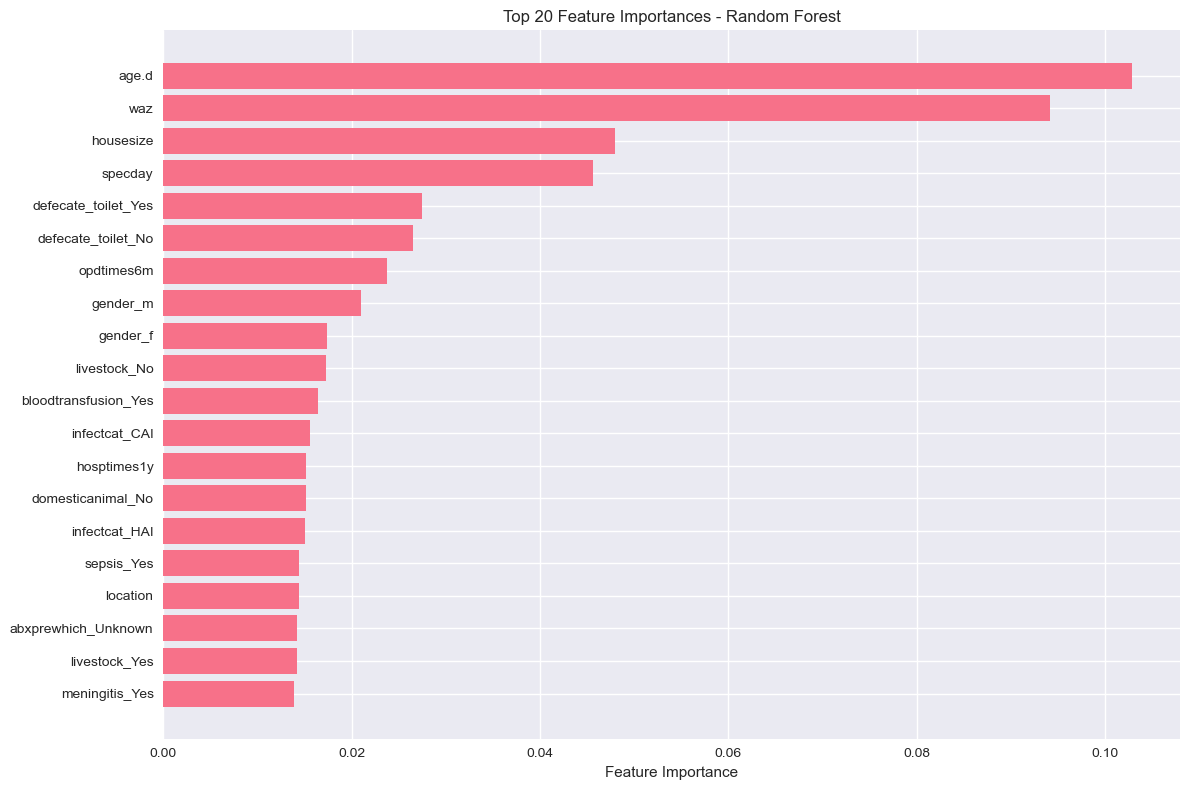

Top 10 Most Important Features:
----------------------------------------
 1. age.d                          0.1028
 2. waz                            0.0942
 3. housesize                      0.0480
 4. specday                        0.0456
 5. defecate_toilet_Yes            0.0274
 6. defecate_toilet_No             0.0265
 7. opdtimes6m                     0.0238
 8. gender_m                       0.0210
 9. gender_f                       0.0174
10. livestock_No                   0.0173


In [37]:
# Feature importance analysis for tree-based models
if hasattr(best_model, 'feature_importances_'):
    # Get feature importances
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Plot top 20 features
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(20)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 20 Feature Importances - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("Top 10 Most Important Features:")
    print("-" * 40)
    for i, (idx, row) in enumerate(feature_importance.head(10).iterrows(), 1):
        print(f"{i:2d}. {row['feature']:30s} {row['importance']:.4f}")

elif best_model_name == 'Logistic Regression':
    # For logistic regression, use coefficient magnitudes
    coef_importance = pd.DataFrame({
        'feature': X.columns,
        'coefficient': best_model.coef_[0],
        'abs_coefficient': np.abs(best_model.coef_[0])
    }).sort_values('abs_coefficient', ascending=False)
    
    # Plot top 20 features
    plt.figure(figsize=(12, 8))
    top_features = coef_importance.head(20)
    colors = ['red' if x < 0 else 'blue' for x in top_features['coefficient']]
    plt.barh(range(len(top_features)), top_features['coefficient'], color=colors)
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Coefficient Value')
    plt.title(f'Top 20 Feature Coefficients - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("Top 10 Most Important Features (by coefficient magnitude):")
    print("-" * 60)
    for i, (idx, row) in enumerate(coef_importance.head(10).iterrows(), 1):
        direction = "↑" if row['coefficient'] > 0 else "↓"
        print(f"{i:2d}. {row['feature']:30s} {row['coefficient']:8.4f} {direction}")

else:
    print(f"Feature importance analysis not available for {best_model_name}")

## 7. Model Validation and Clinical Considerations

### Statistical Significance Testing
We can use statistical tests to determine if differences between models are significant.

In [38]:
# Statistical comparison of models
from scipy.stats import ttest_rel

print("Statistical Comparison of Model Performance")
print("=" * 50)

# Compare top 3 models pairwise
for i in range(len(top_3_models)):
    for j in range(i+1, len(top_3_models)):
        model1, model2 = top_3_models[i], top_3_models[j]
        scores1, scores2 = cv_scores[model1], cv_scores[model2]
        
        # Paired t-test
        statistic, p_value = ttest_rel(scores1, scores2)
        
        mean_diff = scores1.mean() - scores2.mean()
        significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
        
        print(f"{model1} vs {model2}:")
        print(f"  Mean difference: {mean_diff:+.4f}")
        print(f"  p-value: {p_value:.4f} {significance}")
        print()

# Clinical decision thresholds
print("Clinical Decision Analysis")
print("=" * 30)

# Evaluate performance at different probability thresholds
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]

# Use the best model for threshold analysis
if best_model_name in ['Logistic Regression', 'SVM', 'KNN', 'Naive Bayes']:
    X_test_input = X_test_scaled
else:
    X_test_input = X_test

best_model.fit(X_train_input if best_model_name in ['Logistic Regression', 'SVM', 'KNN', 'Naive Bayes'] else X_train, y_train)
y_pred_proba = best_model.predict_proba(X_test_input)[:, 1]

print(f"Threshold analysis for {best_model_name}:")
print(f"{'Threshold':<10} {'Sensitivity':<11} {'Specificity':<11} {'PPV':<8} {'NPV':<8}")
print("-" * 50)

for threshold in thresholds:
    y_pred_thresh = (y_pred_proba >= threshold).astype(int)
    
    # Calculate metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()
    
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  # Positive Predictive Value
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value
    
    print(f"{threshold:<10.1f} {sensitivity:<11.3f} {specificity:<11.3f} {ppv:<8.3f} {npv:<8.3f}")

print("\nClinical Interpretation:")
print("- High Sensitivity (low threshold): Catches most resistant cases, fewer treatment failures")
print("- High Specificity (high threshold): Reduces unnecessary broad-spectrum therapy")
print("- Balance depends on clinical priorities and local resistance patterns")

Statistical Comparison of Model Performance
Random Forest vs SVM:
  Mean difference: +0.0223
  p-value: 0.5579 

Random Forest vs KNN:
  Mean difference: +0.0326
  p-value: 0.5288 

SVM vs KNN:
  Mean difference: +0.0103
  p-value: 0.8360 

Clinical Decision Analysis
Threshold analysis for Random Forest:
Threshold  Sensitivity Specificity PPV      NPV     
--------------------------------------------------
0.3        1.000       0.176       0.696    1.000   
0.4        0.969       0.294       0.721    0.833   
0.5        0.719       0.471       0.719    0.471   
0.6        0.562       0.588       0.720    0.417   
0.7        0.219       0.824       0.700    0.359   

Clinical Interpretation:
- High Sensitivity (low threshold): Catches most resistant cases, fewer treatment failures
- High Specificity (high threshold): Reduces unnecessary broad-spectrum therapy
- Balance depends on clinical priorities and local resistance patterns


## 8. Model Persistence and Deployment Preparation

Save the final optimized model for use in Day 4.

In [42]:
# Save the optimized model and preprocessing components
model_artifacts = {
    'model': best_model,
    'scaler': scaler,
    'feature_names': X.columns.tolist(),
    'model_name': best_model_name,
    'cv_score': cv_scores[best_model_name].mean(),
    'cv_std': cv_scores[best_model_name].std(),
    'target_names': ['Not Treatable', 'Treatable']
}

# Save to file
joblib.dump(model_artifacts, '../MODELS/resistance_model_optimized.pkl')

print("Model artifacts saved successfully!")
print(f"Final model: {best_model_name}")
print(f"Cross-validation AUC: {model_artifacts['cv_score']:.3f} ± {model_artifacts['cv_std']:.3f}")
print(f"Number of features: {len(model_artifacts['feature_names'])}")
print(f"Saved to: resistance_model_optimized.pkl")

# Create a summary report
summary_report = f"""
ESCMID AI Course - Day 2 Model Development Summary
================================================

Dataset: AHC Final Dataset
Samples: {X.shape[0]}
Features: {X.shape[1]}
Target: amp.gent.treatable (binary classification)

Class Distribution:
- Treatable (Y): {(y_binary == 1).sum()} ({(y_binary == 1).mean():.1%})
- Not Treatable (N): {(y_binary == 0).sum()} ({(y_binary == 0).mean():.1%})

Models Evaluated:
{chr(10).join([f"- {name}: AUC {scores.mean():.3f} ± {scores.std():.3f}" for name, scores in cv_scores.items()])}

Best Model: {best_model_name}
Cross-validation AUC: {model_artifacts['cv_score']:.3f} ± {model_artifacts['cv_std']:.3f}

Key Findings:
- Cross-validation provides robust performance estimates
- {best_model_name} performed best among tested algorithms
- Feature importance analysis reveals clinical insights
- Model ready for deployment and external validation

Next Steps:
- Validate on external datasets
- Implement in clinical decision support system
- Monitor performance in real-world deployment
"""

print(summary_report)

# Save summary report
with open('../MODELS/model_summary.txt', 'w') as f:
    f.write(summary_report)

print("Summary report saved to model_summary.txt")

Model artifacts saved successfully!
Final model: Random Forest
Cross-validation AUC: 0.660 ± 0.029
Number of features: 64
Saved to: resistance_model_optimized.pkl

ESCMID AI Course - Day 2 Model Development Summary

Dataset: AHC Final Dataset
Samples: 243
Features: 64
Target: amp.gent.treatable (binary classification)

Class Distribution:
- Treatable (Y): 158 (65.0%)
- Not Treatable (N): 85 (35.0%)

Models Evaluated:
- Logistic Regression: AUC 0.561 ± 0.047
- Random Forest: AUC 0.660 ± 0.029
- Gradient Boosting: AUC 0.543 ± 0.062
- SVM: AUC 0.638 ± 0.087
- Naive Bayes: AUC 0.590 ± 0.054
- KNN: AUC 0.627 ± 0.093

Best Model: Random Forest
Cross-validation AUC: 0.660 ± 0.029

Key Findings:
- Cross-validation provides robust performance estimates
- Random Forest performed best among tested algorithms
- Feature importance analysis reveals clinical insights
- Model ready for deployment and external validation

Next Steps:
- Validate on external datasets
- Implement in clinical decision supp

## Summary and Key Takeaways

### What We Accomplished
1. **Comprehensive Model Comparison**: Evaluated 6 different machine learning algorithms
2. **Robust Validation**: Used stratified k-fold cross-validation for reliable performance estimates
3. **Hyperparameter Optimization**: Tuned the best performing model using grid search
4. **Feature Analysis**: Identified the most important predictors of antibiotic resistance
5. **Clinical Interpretation**: Analyzed performance metrics in clinical context
6. **Statistical Validation**: Performed significance testing between models

### Key Learning Points

#### Machine Learning Best Practices
- **Always use cross-validation** for model selection and performance estimation
- **Handle class imbalance** with appropriate techniques (balanced class weights, stratified sampling)
- **Scale features** for algorithms sensitive to feature magnitude
- **Compare multiple algorithms** before settling on one approach
- **Tune hyperparameters** systematically using grid search or random search

#### Performance Metrics in Healthcare
- **Accuracy alone is insufficient** for imbalanced datasets
- **AUC-ROC** is good for overall discriminative ability
- **AUC-PR** is better for imbalanced classes
- **Sensitivity vs Specificity trade-off** must consider clinical consequences
- **Threshold selection** should be based on clinical priorities

#### Clinical Decision Making
- **False negatives** (missing resistant cases) can lead to treatment failure
- **False positives** (predicting resistance when there isn't any) lead to unnecessary broad-spectrum therapy
- **Optimal threshold** depends on local resistance patterns and treatment options
- **Model interpretability** is crucial for clinical adoption

### Next Steps
This model is now ready for:
1. **External validation** on independent datasets
2. **Prospective evaluation** in clinical settings
3. **Integration** into clinical decision support systems
4. **Continuous monitoring** and updating as new data becomes available

In [40]:
model_artifacts

{'model': RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200,
                        random_state=42),
 'scaler': StandardScaler(),
 'feature_names': ['location',
  'age.d',
  'waz',
  'hosptimes1y',
  'opdtimes6m',
  'housesize',
  'specday',
  'gender_f',
  'gender_m',
  'icu.vent_No',
  'icu.vent_Yes',
  'surgery_No',
  'surgery_Yes',
  'bloodtransfusion_No',
  'bloodtransfusion_Yes',
  'transfer_No',
  'transfer_Yes',
  'sepsis_No',
  'sepsis_Yes',
  'meningitis_No',
  'meningitis_Yes',
  'lrti_No',
  'lrti_Yes',
  'urti_No',
  'urti_Yes',
  'diarrhoea_No',
  'diarrhoea_Yes',
  'cellulitis_No',
  'cellulitis_Yes',
  'abscess_No',
  'abscess_Yes',
  'uti_No',
  'uti_Yes',
  'pharmpre_No',
  'pharmpre_Yes',
  'nursepre_No',
  'nursepre_Yes',
  'khrupre_No',
  'khrupre_Yes',
  'ivfluidpre_No',
  'ivfluidpre_Yes',
  'medpre_No',
  'medpre_Yes',
  'abxprewhich_AnyTBdrugs',
  'abxprewhich_PenicillinFamily',
  'abxprewhich_Unknown',
  'domesticanimal_No',
  'd